# MPI-AMRVAC dataset analysis with yt

This notebook contains examples and instructions specific to the MPI-AMRVAC frontend in yt. 

For a (much) more detailed guide we refer to [the yt cookbook](https://yt-project.org/doc/cookbook/index.html). An overview of the latest news and updates regarding our frontend can be found on [the AMRVAC website](http://amrvac.org/md_doc_yt_usage.html).

Niels Claes and Clément Robert are the current maintainers of both this notebook and the AMRVAC frontend. If you have any ideas or requests for stuff to add here, feel free to contact us. If you encounter issues or bugs regarding the frontend itself, send us a message through the [yt Slack](https://yt-project.org/doc/help/index.html#go-on-slack-or-irc-to-ask-a-question) (we have a dedicated **#amrvac** channel) or file [an issue on GitHub](https://github.com/yt-project/yt/issues).

Please make sure to mention the AMRVAC frontend in the issue header, and feel free to ping either Niels ([@n-claes](https://github.com/n-claes)) or Clément ([@neutrinoceros](https://github.com/neutrinoceros)) in the issue description!

# Loading datfiles

We include three datfiles in the `data` subfolder: 
- `blastwave_2d.dat` : the 2D MHD blastwave from the amrvac tests folder
- `25d_prominence.dat` : a 2.5D Cartesian dataset of a solar prominence
- `jet_3d.dat` : a 3D Cartesian dataset of an astrophysical jet

where the latter two datasets were kindly provided by Rony Keppens.

Starting from AMRVAC [version 2.2](https://github.com/amrvac/amrvac/releases) we added a few things to the datfile header to improve compatibility with yt. Amongst these was a `geometry` parameter, which enables yt to directly parse the geometry information from the datfile. Loading datfiles from previous code versions is possible since we ensured backwards compatibility up to AMRVAC 2.0, although in that case those parameters should be added manually since older datfile versions do not have those flags. An example is given below for the 2D blastwave, made with version 2.1.

In [1]:
blastwave = 'data/blastwave_2d.dat'
prominence = 'data/25d_prominence.dat'
jet = 'data/jet_3d.dat'

Naturally, we start by importing the `yt` package.

In [2]:
import yt

## 2D MHD blastwave

As a first example to start from, we take a look at the 2D MHD blastwave.

In [3]:
ds = yt.load(blastwave)

yt : [WARNING  ] 2020-03-18 19:45:04,581 No geometry parameter supplied or found, defaulting to cartesian.
yt : [INFO     ] 2020-03-18 19:45:04,617 Parameters: current_time              = 0.15
yt : [INFO     ] 2020-03-18 19:45:04,618 Parameters: domain_dimensions         = [32 32  1]
yt : [INFO     ] 2020-03-18 19:45:04,618 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-18 19:45:04,619 Parameters: domain_right_edge         = [2. 2. 1.]
yt : [INFO     ] 2020-03-18 19:45:04,620 Parameters: cosmological_simulation   = 0


As mentioned above, since no geometry information is present in the datfile, yt logs a warning during loading and defaults to `'Cartesian'`. Since this is a Cartesian dataset, this is fine. However, if the geometry would be anything else, we have to supply a `geometry_override` parameter as keyword argument, which can be `'Cartesian', 'polar', 'spherical'` or `'cylindrical'`. Dataset dimensions are automatically inferred from the datfile and do not have to be supplied.

**Note**: The `geometry_override` flag has priority over the `geometry` flag present in recent (> v2.2) datfiles, which means that it can be used to _force_ datasets into another coordinate system. Note that this can produce undesired behaviour, and comes with no guarantee. Below we show how to load the blastwave dataset in the case of a polar geometry.

In [4]:
ds_temp = yt.load(blastwave, geometry_override='polar')
del ds_temp

yt : [WARNING  ] 2020-03-18 19:46:30,655 Overriding geometry, this may lead to surprising results.
yt : [INFO     ] 2020-03-18 19:46:30,671 Parameters: current_time              = 0.15
yt : [INFO     ] 2020-03-18 19:46:30,672 Parameters: domain_dimensions         = [32 32  1]
yt : [INFO     ] 2020-03-18 19:46:30,673 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-18 19:46:30,673 Parameters: domain_right_edge         = [2. 2. 1.]
yt : [INFO     ] 2020-03-18 19:46:30,674 Parameters: cosmological_simulation   = 0


`yt` prints information about the dataset when loading, such as the time and domain edges of the current snapshot in code units. When loading multiple files (for example when using time series) it may be useful to reduce or even turn off the info and/or warnings. Doing this is very straightforward, more information can be found [here](https://yt-project.org/docs/dev/faq/index.html#how-can-i-change-yt-s-log-level).

# Unit normalisations

Since MPI-AMRVAC only supports dimensionless fields, in many use cases the `mod_usr.t` file will include unit normalisations (it should, it's good practice), which are actually never attached to the datfile itself. In order to pass these on to yt, we make use of the `units_override` keyword argument, which accepts a dictionary of yt units.

In MPI-AMRVAC a user can only pass a length unit, numberdensity unit and a temperature OR velocity unit (so 2 options), since there are only three degrees of freedom. We _explicitly_ programmed the AMRVAC unit system in yt, so if unit normalisations are provided all fields are redimensionalised in exactly the same way. It's even better actually, since we allowed up to 5 combinations of unit normalisations, with a maximum of three units in each case:

```
{numberdensity_unit, temperature_unit, length_unit}
{mass_unit, temperature_unit, length_unit}
{mass_unit, time_unit, length_unit}
{numberdensity_unit, velocity_unit, length_unit}
{mass_unit, velocity_unit, length_unit}
```
Appropriate errors are thrown for other/wrong combinations. Creating a yt unit dictionary is quite simple, and can be done as such:

In [5]:
units = dict(length_unit=(1e9, 'cm'), temperature_unit=(1e6, 'K'), numberdensity_unit=(1e9, 'cm**-3'))

Note that every normalisation is a tuple, containing the actual value and the unit itself. yt has a very broad range of possibilities, and you can even mix different unit systems - **conversions will be automatically handled by yt**! For example, this works as well:

In [6]:
units_2 = dict(length_unit=(1e8, 'm'), velocity_unit=(1e3, 'km*s**-1'), mass_unit=yt.units.mass_sun)
display(units_2)

{'length_unit': (100000000.0, 'm'),
 'velocity_unit': (1000.0, 'km*s**-1'),
 'mass_unit': 1.98841586e+33 g}

# 2.5D prominence dataset

Since the 2D blastwave is not that interesting visualisation-wise, we immediately move on to the 2.5D prominence simulation. This run was done with AMRVAC 2.2, and hence contains the `geometry` flag. We can also supply the unit normalisations we just defined during loading.

In [7]:
ds = yt.load(prominence, units_override=units, unit_system='cgs')

yt : [WARNING  ] 2020-03-18 19:48:49,774 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2020-03-18 19:48:49,774 Overriding length_unit: 1e+09 cm.
yt : [INFO     ] 2020-03-18 19:48:49,775 Overriding temperature_unit: 1e+06 K.
yt : [INFO     ] 2020-03-18 19:48:49,776 Overriding numberdensity_unit: 1e+09 cm**-3.
yt : [INFO     ] 2020-03-18 19:48:49,791 Parameters: current_time              = 45.0
yt : [INFO     ] 2020-03-18 19:48:49,792 Parameters: domain_dimensions         = [256 256   1]
yt : [INFO     ] 2020-03-18 19:48:49,793 Parameters: domain_left_edge          = [-3.  0.  0.]
yt : [INFO     ] 2020-03-18 19:48:49,794 Parameters: domain_right_edge         = [3. 6. 1.]
yt : [INFO     ] 2020-03-18 19:48:49,794 Parameters: cosmological_simulation   = 0


Note that yt explicitly prints a message to the console stating which units are overridden. You may also notice that we supplied another keyword argument, `unit_system`. In yt, there are three ways to display information on plots: either in cgs, SI (mks) or code units. The cgs unit system is the default one that will be used if `unit_system` is not specified. In other words, all lengths will be read in as `'cm'` unless specified otherwise. To see the difference, we make a simple 2D plot of the density field in the three unit systems below.

In [9]:
# to prevent console cluttering, we temporarily disable info and warning messages
from yt.funcs import mylog
mylog.setLevel(40)


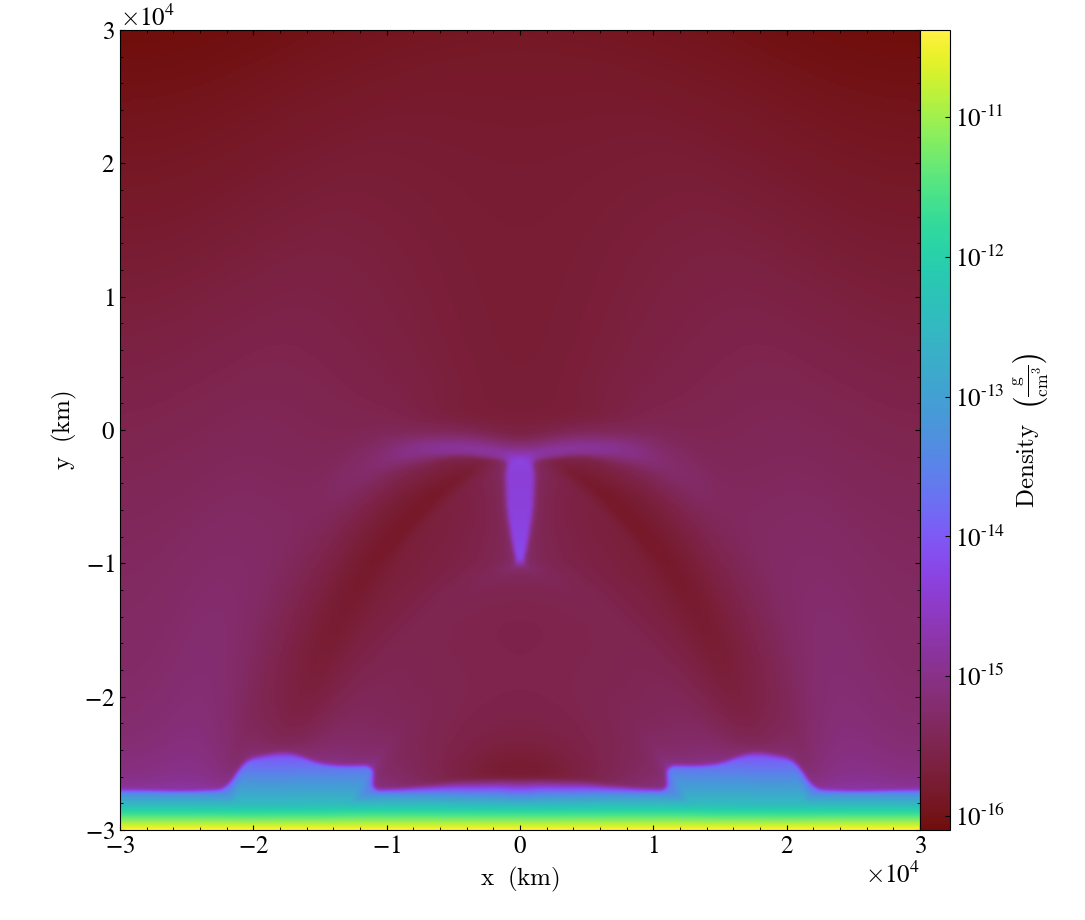


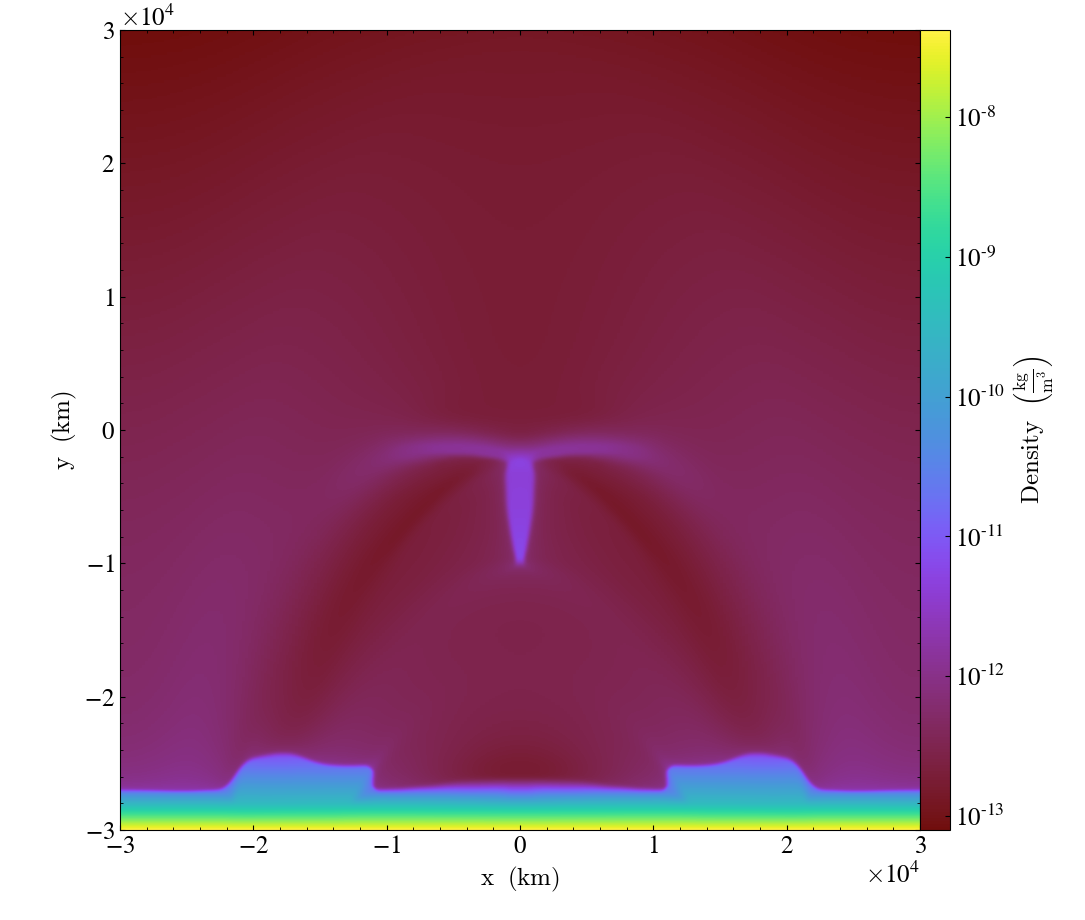


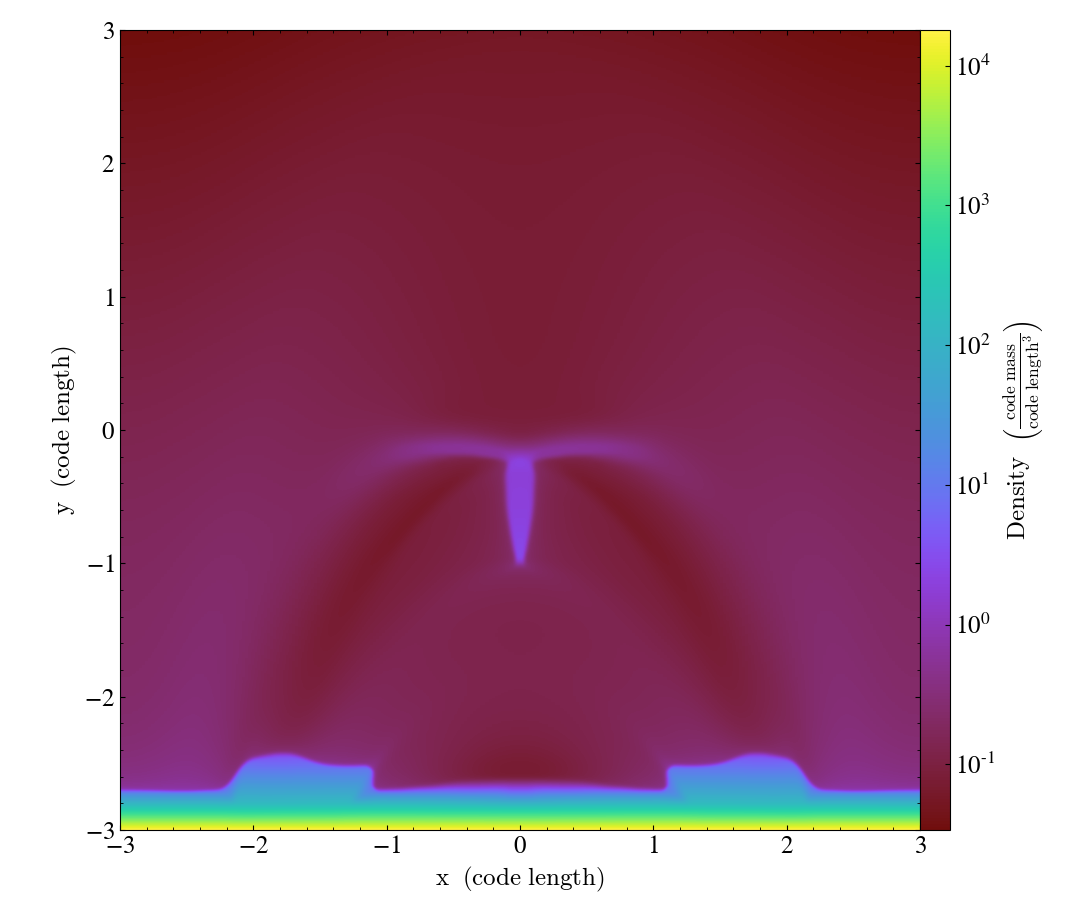

In [10]:
ds_cgs  = yt.load(prominence, units_override=units, unit_system='cgs')
ds_si   = yt.load(prominence, units_override=units, unit_system='mks')
ds_code =yt.load(prominence, units_override=units, unit_system='code')

p_cgs  = yt.plot_2d(ds_cgs, 'density').show()
p_si   = yt.plot_2d(ds_si, 'density').show()
p_code = yt.plot_2d(ds_code, 'density').show()

In [11]:
# re-enable log messages
mylog.setLevel(20)

Note the difference in axis scales, especially the colorbar scale and labels. Of course, you can customise these individually as well. You may have noticed that providing the field `'density'` (obviously) plots the density field. To see the fields that are present _in the datfile,_ you can call

In [12]:
ds.field_list

[('amrvac', 'b1'),
 ('amrvac', 'b2'),
 ('amrvac', 'b3'),
 ('amrvac', 'e'),
 ('amrvac', 'm1'),
 ('amrvac', 'm2'),
 ('amrvac', 'm3'),
 ('amrvac', 'rho')]

It should be noted that the fields in the datfile (hence the ones that come straight out of AMRVAC) are always in code units. That's also why the first argument is `'amrvac'`, in order to distinguish them from standard yt fields. However, these are not the only fields that yt knows. To see all fields that yt _thinks_ it knows, you can call

In [13]:
ds.derived_field_list

[('amrvac', 'b1'),
 ('amrvac', 'b2'),
 ('amrvac', 'b3'),
 ('amrvac', 'cell_volume'),
 ('amrvac', 'dx'),
 ('amrvac', 'dy'),
 ('amrvac', 'dz'),
 ('amrvac', 'e'),
 ('amrvac', 'm1'),
 ('amrvac', 'm2'),
 ('amrvac', 'm3'),
 ('amrvac', 'path_element_x'),
 ('amrvac', 'path_element_y'),
 ('amrvac', 'path_element_z'),
 ('amrvac', 'rho'),
 ('amrvac', 'vertex_x'),
 ('amrvac', 'vertex_y'),
 ('amrvac', 'vertex_z'),
 ('amrvac', 'x'),
 ('amrvac', 'y'),
 ('amrvac', 'z'),
 ('gas', 'H_nuclei_density'),
 ('gas', 'He_nuclei_density'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'courant_time_step'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('gas', 'density_gradient_y'),
 ('gas', 'density_gradient_z'),
 ('gas', 'dx'),
 ('gas', 'dy'),
 ('gas', 'dynamical_time'),
 ('gas', 'dz'),
 (

Note that these also contain the fields from the datfile itself. All fields with first argument `'gas'` are in the unit system specified during loading. The ones with `'index'` are used internally by yt.

We extended these fields with the _kinetic energy density, sound speed, mach number_ and _thermal pressure_. Since AMRVAC can do simulations in (adiabatic) (magneto)hydrodynamics by setting for example `mhd_energy=.false.` in the parfile, we actually **reconstruct the equation of state** from information contained in the datfile. When these fields are set up, yt will print an info message saying which EoS is used. If yt is unable to reconstruct the EoS it will print a warning stating that the thermal pressure field, and by extension derived fields thereof, are not set.

Since the 2.5D dataset here was done in full MHD, yt logs `using the full MHD energy for thermal pressure`, as it should. Note that this is done _exactly once_ when setting up the derived fields, usually when executing a plot command for the first time. All subsequent calls will not have this info message, since these fields have already been set.

yt : [INFO     ] 2020-03-18 19:49:26,870 Using full MHD energy for thermal pressure.
yt : [INFO     ] 2020-03-18 19:49:28,572 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-03-18 19:49:28,573 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-03-18 19:49:28,574 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-03-18 19:49:28,574 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-03-18 19:49:28,580 Making a fixed resolution buffer of (('gas', 'thermal_pressure')) 800 by 800



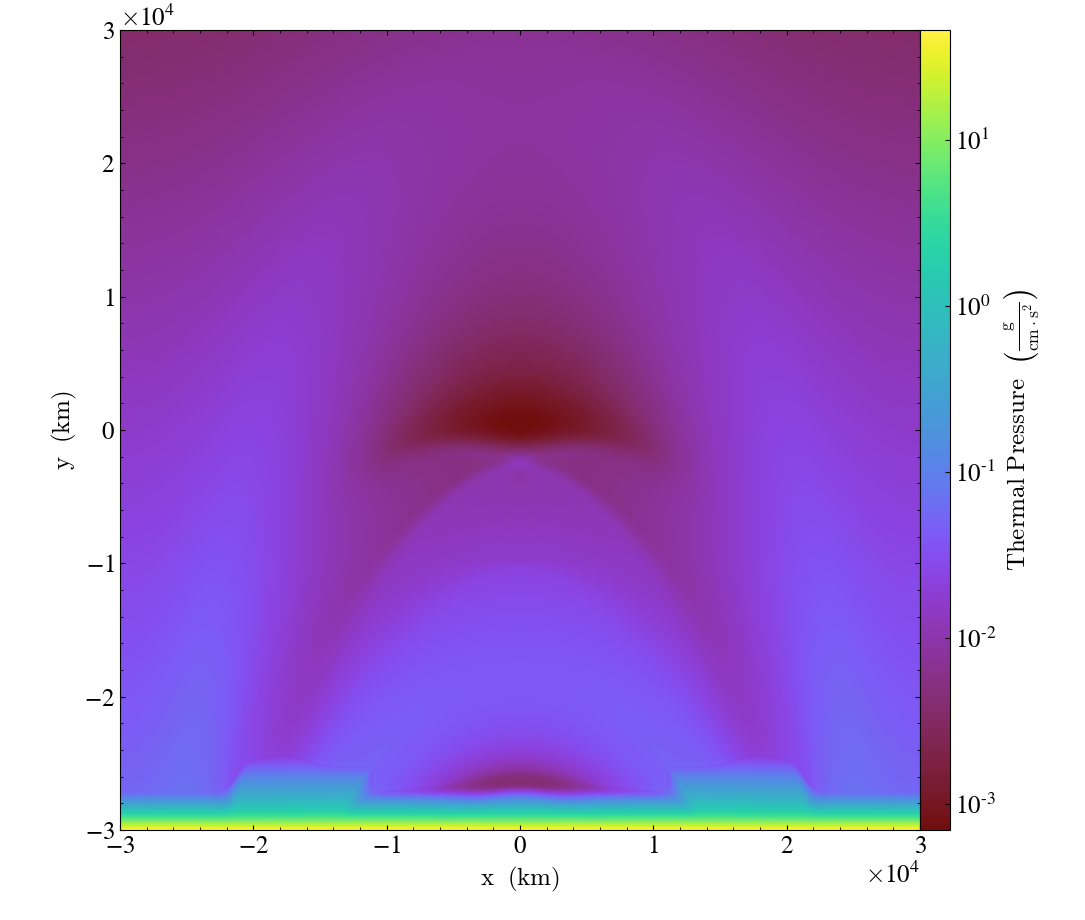

In [8]:
yt.plot_2d(ds, 'thermal_pressure')